In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from utils.angle_data import get_data, AngleData, SingleRun
from utils.style import make_style
import mplhep as hep
make_style()

from jacobi import propagate
from iminuit import Minuit
from iminuit.pdg_format import pdg_format

from iminuit.cost import LeastSquares
import glob


# Gold-Film (Au) sample fitting

The complete analysis for the gold layer is made just from considering the 1-layer fresnel approximation, omimtting the possibility of any two or three layer system. 

In [2]:
p_Au_ADL_ = get_data(sorted(glob.glob('../data/dataAu_1/**')), 23)
s_Au_ADL_ = get_data(sorted(glob.glob('../data/dataAu_0/**')), 23)

s_Au = SingleRun(s_Au_ADL_, s_Au_ADL_[-1])
p_Au = SingleRun(p_Au_ADL_, p_Au_ADL_[-1])

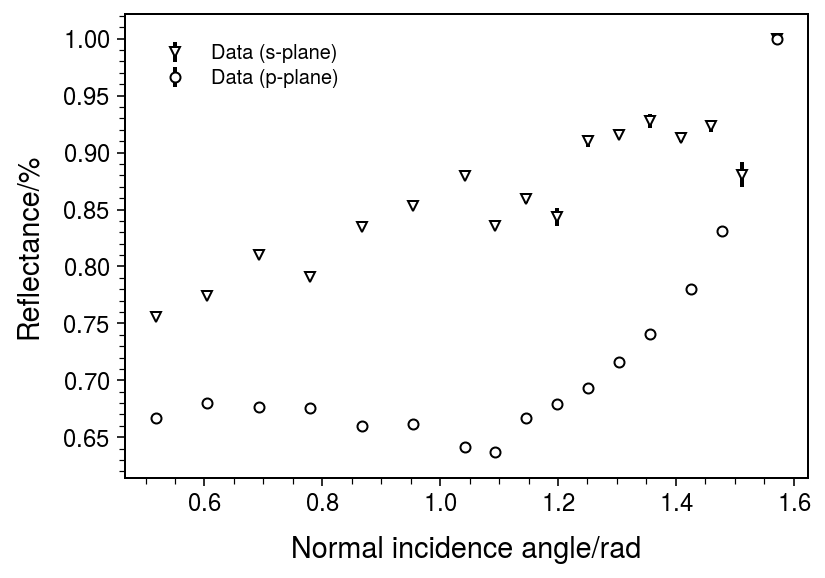

In [3]:
s_Au.plot(marker='v')
p_Au.plot(marker='o')
plt.legend()

In [4]:
def r_p(theta, ni, nt):
    '''Compute r_p fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (nt * np.cos(theta) - ni * cos_transmitted) / (ni * cos_transmitted + nt * np.cos(theta))
    )

def r_s(theta, ni, nt):
    '''Compute r_s fresnel coefficient
    
    Parameters:
    `theta`: incident angle, expressed in radians
    `n1`: complex refractive indices for material 1 (n = n + k*1j)
    `n2`: complex refractive indices for material 2 (n = n + k*1j)
    '''
    
    cos_transmitted = np.sqrt(1 - ((ni/nt) * np.sin(theta))**2)
    return (
        (ni * np.cos(theta) - nt * cos_transmitted) / (ni * np.cos(theta) + nt * cos_transmitted)
    )

def Au_Rs(theta, n1, n2, phase):
    rs = r_s(theta-phase, n1, n2)
    return np.abs( rs * np.conj(rs) )

def Au_Rp(theta, n1, n2, phase):
    rp = r_p(theta-phase, n1, n2)
    return np.abs( rp * np.conj(rp) )

## CommRR$\chi^2$ model, using LS from `iminuit`

In [5]:
n_Air  = 1.00027821
n_Au   = 0.54463
k_Au   = 2.1406

parameters = [n_Air, 0, n_Au, k_Au, 0]

modelRs = lambda x, p: Au_Rs(x, p[0]+p[1]*1j, p[2]+p[3]*1j, p[4])
modelRp = lambda x, p: Au_Rp(x, p[0]+p[1]*1j, p[2]+p[3]*1j, p[4])

CommRRChi2 = (
    LeastSquares(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std, model=modelRs) + 
    LeastSquares(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std, model=modelRp)
)

CommRRC2MM = Minuit(CommRRChi2, parameters)

# Fixing Air values
CommRRC2MM.fixed[0] = True
CommRRC2MM.fixed[1] = True

# CommRRC2MM.limits[2] = (0,2)
# CommRRC2MM.limits[2] = (0,3)

CommRRC2MM.migrad()
CommRRC2MM.hesse()
CommRRC2MM.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2116 (chi2/ndof = 70.5)    │              Nfcn = 136              │
│ EDM = 3.11e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │  0.3233   │  0.0029   │            │            │         │         │       │
│ 3 │ x3   │   1.750   │   0.011   │            │            │         │         │       │
│ 4 │ x4   │  0.0200   │  0.0015   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0  8.54e-06  3.26e-05 -2.54e-06 │
│ x3 │         0         0  3.26e-05   0.00013 -8.72e-06 │
│ x4 │         0         0 -2.54e-06 -8.72e-06  2.38e-06 │
└────┴───────────────────────────────────────────────────┘

In [6]:
def CLs_plot(m: Minuit, model: callable, cx, parameters, color):
    y, ycov = propagate(lambda p: model(cx, p), m.values, m.covariance)
    plt.plot(cx,y,color=color)
    # plt.plot(cx, model(cx, parameters), 'k:')
    yerr_prop = np.diag(ycov) ** 0.5
    plt.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor=color, alpha=0.5)

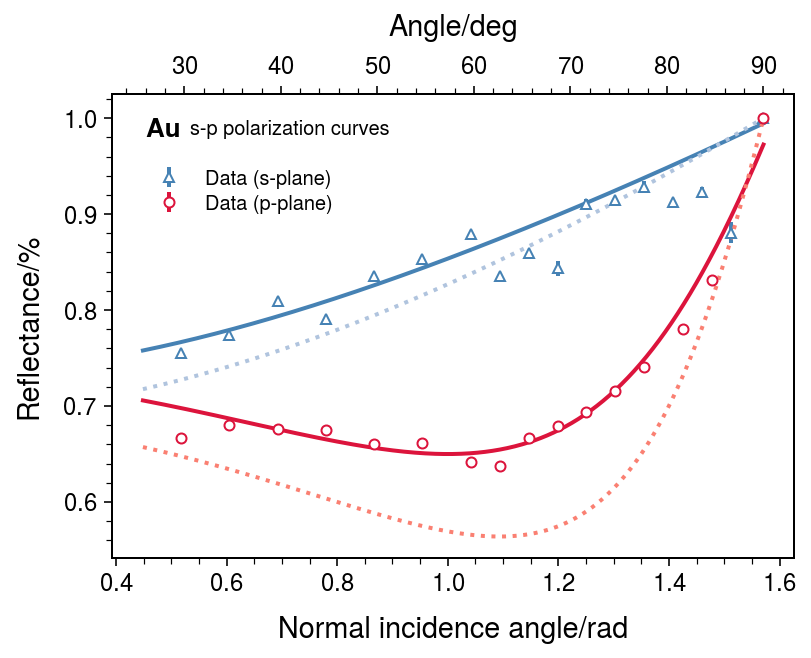

In [7]:
s_color = 'steelblue'
p_color = 'crimson'

angles = np.linspace(np.pi/7, np.pi/2, 500)

s_Au.plot(marker='^', color=s_color)
p_Au.plot(color=p_color)

hep.label.exp_text('Au ', 's-p polarization curves', loc=1)

CLs_plot(CommRRC2MM, modelRp, angles, parameters, p_color)
CLs_plot(CommRRC2MM, modelRs, angles, parameters, s_color)

plt.plot(angles, Au_Rs(angles, n_Air, n_Au+k_Au*1j,0), color='lightsteelblue', ls=':')
plt.plot(angles, Au_Rp(angles, n_Air, n_Au+k_Au*1j,0), color='salmon', ls=':')


ax = plt.gca().secondary_xaxis('top', functions=(np.rad2deg, np.deg2rad))
ax.set_xlabel('Angle/deg')

plt.legend(loc=(0.025, 0.7))
plt.savefig('../figures/Au_Rs_Rp.pdf', bbox_inches='tight')

In [8]:
from uncertainties import ufloat

names = {
    'nAir': 'n_\mathrm{Air}',
    'kAir': '\kappa_\mathrm{Air}',
    'nAu': 'n_\mathrm{Au}',
    'kAu': '\kappa_\mathrm{Au}',
    'phase': '\phi'
}

theorehical_values = {
    'nAir':  1.00027821,
    'kAir': 0,
    'nAu': 0.54463,
    'kAu': 2.1406,
    'phase': 0
}

for v, e, n in zip(CommRRC2MM.values, CommRRC2MM.errors, names.keys()):
    print(f'{n}: {ufloat(v,e):.uSL}')

nAir: 1.000(10)
kAir: 0.00(10)
nAu: 0.3233(29)
kAu: 1.750(11)
phase: 0.0200(15)


## Indipendently fitted models



In [9]:

RsChi2 = LeastSquares(s_Au.angles, s_Au.reflectance, s_Au.reflectance_std, model=modelRs) 
RpChi2 = LeastSquares(p_Au.angles, p_Au.reflectance, p_Au.reflectance_std, model=modelRp)

RsC2MM = Minuit(RsChi2, parameters)
RpC2MM = Minuit(RpChi2, parameters)


# Fixing Air values
RsC2MM.fixed[0] = True
RsC2MM.fixed[1] = True
RpC2MM.fixed[0] = True
RpC2MM.fixed[1] = True


In [10]:



RpC2MM.migrad()
RpC2MM.hesse()
RpC2MM.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 454.5 (chi2/ndof = 35.0)   │              Nfcn = 127              │
│ EDM = 8.46e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   0.328   │   0.004   │            │            │         │         │       │
│ 3 │ x3   │   1.768   │   0.016   │            │            │         │         │       │
│ 4 │ x4   │  0.0170   │  0.0022   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0  1.39e-05  5.87e-05    -6e-06 │
│ x3 │         0         0  5.87e-05  0.000259 -2.56e-05 │
│ x4 │         0         0    -6e-06 -2.56e-05  4.75e-06 │
└────┴───────────────────────────────────────────────────┘

In [11]:


RsC2MM.migrad()
RsC2MM.hesse()
RsC2MM.migrad()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1578 (chi2/ndof = 112.7)   │              Nfcn = 298              │
│ EDM = 6.49e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 1 │ x1   │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 2 │ x2   │   0.171   │   0.007   │            │            │         │         │       │
│ 3 │ x3   │   1.04    │   0.05    │            │            │         │         │       │
│ 4 │ x4   │   0.063   │   0.006   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0  5.23e-05   0.00034 -3.51e-05 │
│ x3 │         0         0   0.00034   0.00226 -0.000206 │
│ x4 │         0         0 -3.51e-05 -0.000206  3.97e-05 │
└────┴───────────────────────────────────────────────────┘

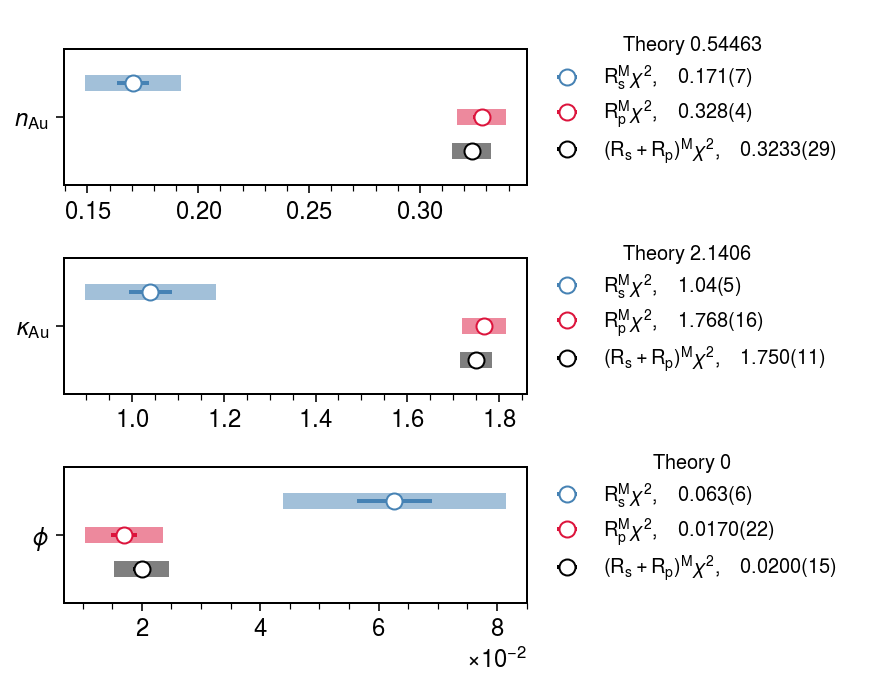

In [16]:

def p_plot(RsM: Minuit, RpM: Minuit, RRM: Minuit, names: dict, th_values: dict, plot_fixed=True):
    
    s_color = 'steelblue'
    p_color = 'crimson'
    
    if plot_fixed:
        N = np.count_nonzero(~RRM.fixed)
    else:
        N = RRM.npar
    
    fig, axs = plt.subplots(N, 1, figsize=(4.0, 1.5 * N))
    fig.tight_layout()
    
    RsMData = np.array([RsM.values, RsM.errors]).T
    RpMData = np.array([RpM.values, RpM.errors]).T
    RRMData = np.array([RRM.values, RRM.errors]).T
    
    j=0
    
    for i, (Rs, Rp, RR, name_key) in enumerate(zip(RsMData, RpMData, RRMData, names.keys())):
        if plot_fixed:
            if RRM.fixed[i]:
                continue
            else:
                pass
        else:
            pass
        
        axs[j].errorbar(y= 0.1, x=Rs[0], xerr=Rs[1], color=s_color, ecolor=s_color, fmt='o', mfc='w', 
                        label=f'$\mathrm{{R_s^M}}\chi^2, \quad{ufloat(Rs[0], Rs[1]):uSL}$')
        axs[j].errorbar(y= 0.1, x=Rs[0], xerr=3 * Rs[1], color=s_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(s_color, 0.5), zorder=1)
        
        axs[j].errorbar(y= 0.,  x=Rp[0], xerr=Rp[1], color=p_color, ecolor=p_color, fmt='o', mfc='w', 
                        label=f'$\mathrm{{R_p^M}}\chi^2, \quad{ufloat(Rp[0], Rp[1]):uSL}$')
        axs[j].errorbar(y= 0.,  x=Rp[0], xerr=3 * Rp[1], color=p_color, fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba(p_color, 0.5), zorder=1)
        
        axs[j].errorbar(y=-0.1, x=RR[0], xerr=RR[1], color='k', ecolor='k', fmt='o', mfc='w', 
                        label=f'$\mathrm{{(R_s+R_p)^M}}\chi^2, \quad{ufloat(RR[0], RR[1]):uSL}$')
        axs[j].errorbar(y=-0.1, x=RR[0], xerr=3 * RR[1], color='k', fmt='.', elinewidth=8, ecolor=mpl.colors.to_rgba('k', 0.5), zorder=1)
        
        axs[j].set_ylim(-0.2, 0.2)
        axs[j].set_yticks(ticks=[0.], labels=[f'${names[name_key]}$'])
        # axs[j].axvline(th_values[name_key], color='k', ls=':', lw='1')
        axs[j].legend(loc=(1.,0), title=f'Theory ${th_values[name_key]}$')
        
        j += 1

p_plot(RsC2MM, RpC2MM, CommRRC2MM, names, theorehical_values)
plt.savefig('../figures/Au_results_all.pdf', bbox_inches='tight')